# Week 6  - An introduction to machine learning (Part II)
### Motivation

Continuation of last week's lecture on ML regression techniques to classification: first we'll look at the Titanic dataset, then the classic [MNIST](http://yann.lecun.com/exdb/mnist/) digit recognition problem, introducing cross validation and hyperparameter search along the way.

In the recap lecture, I'll briefly show how these techniques can be applied to natural language, by analysing the 100K MovieLens [dataset](https://grouplens.org/datasets/movielens/).


### Aims

- Examine how use ML learning to predict the survival chances of Titanic passengers.
- Show how machine learning techniques are not restricted to working with tables of numbers, by automatically classifying digits in the classic ML image recognition problem on the "MNIST" dataset.
- Show how we can be more systematic about how we pick the 'best' model, but introducting metrics, cross-validation, hyperparameter search.
- Introduce the homework with a hands-on with data from a [nature machine intelligence](https://www.nature.com/natmachintell/) paper, ["An interpretable mortality prediction model for COVID-19 patients"](https://www.nature.com/articles/s42256-020-0180-7).

## 0. Setup

Refer to setup instructions from Lecture 5.

## 1. Predicting passenger survival on the Titanic

We base the example on an example analysis from [GitHub](https://github.com/geodra/Titanic-Dataset).

### Titanic datasets

https://web.stanford.edu/class/archive/cs/cs109/cs109.1166/stuff/titanic.csv

https://www.openml.org/d/40945

https://www.openml.org/data/get_csv/16826755/phpMYEkMl

http://bit.ly/1juuXIr

Download and take a look at the data

In [1]:
import urllib, os 

titanic_path = '../data/titanic.csv'
if not os.path.exists(titanic_path):
    urllib.request.urlretrieve('https://www.openml.org/data/get_csv/16826755/phpMYEkMl', titanic_path)

In [2]:
import pandas as pd
titanic = pd.read_csv("../data/titanic.csv")

Let's first explore the dataset to see what we're working with.

In [3]:
titanic.sample(5)

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
291,1,1,"Taussig, Mrs. Emil (Tillie Mandelbaum)",female,39,1,1,110413,79.65,E67,S,8,?,"New York, NY"
45,1,0,"Butt, Major. Archibald Willingham",male,45,0,0,113050,26.55,B38,S,?,?,"Washington, DC"
901,3,0,"Johnston, Miss. Catherine Helen 'Carrie'",female,?,1,2,W./C. 6607,23.45,?,S,?,?,?
1053,3,0,"Nasr, Mr. Mustafa",male,?,0,0,2652,7.2292,?,C,?,?,?
714,3,1,"Chip, Mr. Chang",male,32,0,0,1601,56.4958,?,S,C,?,"Hong Kong New York, NY"


In [4]:
titanic.shape

(1309, 14)

So we can count the missing data, let's replace the `'?'` characters with `None`. We should also extract variables that 'leak' information about the `survived` response (`body`, `boat`); and information we're going to ignore (`home.dest`).

In [5]:
titanic = titanic.replace({'?': None}).drop(['body', 'boat', 'home.dest'], axis=1)

In [6]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   pclass    1309 non-null   int64 
 1   survived  1309 non-null   int64 
 2   name      1309 non-null   object
 3   sex       1309 non-null   object
 4   age       1046 non-null   object
 5   sibsp     1309 non-null   int64 
 6   parch     1309 non-null   int64 
 7   ticket    1309 non-null   object
 8   fare      1308 non-null   object
 9   cabin     295 non-null    object
 10  embarked  1307 non-null   object
dtypes: int64(4), object(7)
memory usage: 112.6+ KB


In [7]:
titanic.describe(include='all')

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
count,1309.000000,1309.000000,1309,1309,1046,1309.000000,1309.000000,1309,1308,295,1307
unique,NaN,NaN,1307,2,98,NaN,NaN,929,281,186,3
top,NaN,NaN,"Kelly, Mr. James",male,24,NaN,NaN,CA. 2343,8.05,C23 C25 C27,S
freq,NaN,NaN,2,843,47,NaN,NaN,11,60,6,914
mean,2.294882,0.381971,NaN,NaN,NaN,0.498854,0.385027,NaN,NaN,NaN,NaN
std,0.837836,0.486055,NaN,NaN,NaN,1.041658,0.865560,NaN,NaN,NaN,NaN
min,1.000000,0.000000,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN
25%,2.000000,0.000000,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN
50%,3.000000,0.000000,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN
75%,3.000000,1.000000,NaN,NaN,NaN,1.000000,0.000000,NaN,NaN,NaN,NaN


In [8]:
titanic['age'] = titanic.age.astype(float)

In [9]:
titanic.survived.value_counts()

0    809
1    500
Name: survived, dtype: int64

Think - what variables might be relevant here, and how might we go about looking at the data to identify relevant features.

Always a good idea to eyeball the data.

In [10]:
titanic['person'] = titanic.apply(lambda x: 'child' if x.age < 18 else x.sex, axis=1)

In [11]:
plot_data = pd.crosstab(index=titanic['person'], columns=titanic['pclass'], values=titanic.index, aggfunc=pd.Series.count).stack().rename("counts").reset_index()

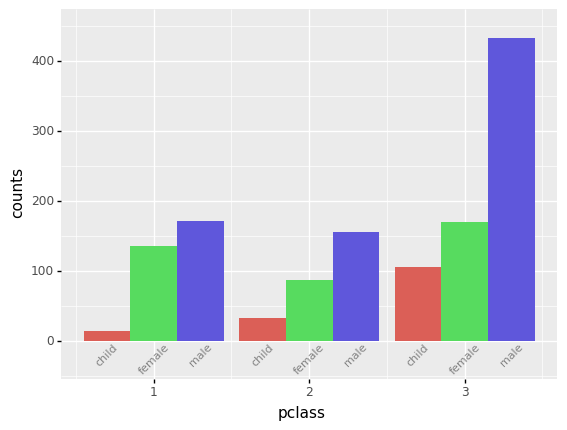

<ggplot: (8765817693389)>

In [12]:
import plotnine as p9
dodge_text = p9.position_dodge(width=0.9) 
(
    p9.ggplot(plot_data, p9.aes(x='pclass', y='counts', fill='person'))
    + p9.geom_col(stat='identity', position='dodge', show_legend=False)
    + p9.geom_text(p9.aes(y=-.5, label='person'),
             position=dodge_text,
             color='gray', size=8, angle=45, va='top')
         + p9.lims(y=(-30, 450))  
)

<AxesSubplot:>

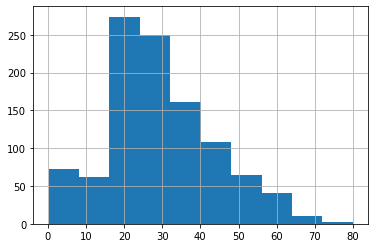

In [13]:
titanic.age.hist()

In [14]:
import numpy as np
import re
from sklearn.model_selection import train_test_split

In [15]:
titanic.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,person
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,female
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.55,C22 C26,S,child
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.55,C22 C26,S,child
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.55,C22 C26,S,male
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.55,C22 C26,S,female


In [16]:
def extract_title(data):
    titles = data.name.apply(lambda x: re.search('([A-Za-z]+)\.', x).group(0))
    l = ['Miss.','Master.','Mr.','Mrs.']
    titles = (
        titles.replace('Mlle.', 'Miss.')
        .replace('Ms.', 'Miss.')
        .replace('Mme.', 'Mrs.')
        .apply(lambda x: 'Rare' if x not in l else x)
    )
    return titles

In [17]:
extract_title(titanic)

0         Miss.
1       Master.
2         Miss.
3           Mr.
4          Mrs.
         ...   
1304      Miss.
1305      Miss.
1306        Mr.
1307        Mr.
1308        Mr.
Name: name, Length: 1309, dtype: object

In [18]:
def impute_age(data):
    from random import randrange, uniform
    
    grouped_means = data.groupby(['sex','pclass','title']).mean().age.reset_index()
    grouped_stds = data.groupby(['sex','pclass','title']).std().age.reset_index()
    
    def fill_age(row):
        condition = (
            (grouped_means['sex'] == row['sex']) & 
            (grouped_means['title'] == row['title']) & 
            (grouped_means['pclass'] == row['pclass'])
        ) 
        mean = grouped_means[condition]['age'].values[0]
        std = grouped_stds[condition]['age'].values[0]
        return uniform(mean-std, mean+std)

    return data.apply(lambda row: fill_age(row) if np.isnan(row['age']) else row['age'], axis=1)


In [19]:
titanic['title'] = extract_title(titanic)
impute_age(titanic)

0       29.000000
1        0.916700
2        2.000000
3       30.000000
4       25.000000
          ...    
1304    14.500000
1305    10.586361
1306    26.500000
1307    27.000000
1308    29.000000
Length: 1309, dtype: float64

In [20]:
def impute_fare(data):
    fare = data.fare.astype(float)
    return fare.fillna(fare.mean())

def impute_embarked(data):
    return data.embarked.fillna(data.embarked.mode()[0])

def binarize_sex(data):
    return data['sex'].apply(lambda x: 1 if x=='male' else 0)

def impute_cabin(data):
    """Fill with model and map each cabin value with the cabin letter."""
    return data.cabin.fillna(data.cabin.mode()).map(lambda c: str(c)[0])

def categorise_pclass(data):
    return data.pclass.astype('category')

In [21]:
titanic.cabin.mode()

0    C23 C25 C27
dtype: object

In [22]:
impute_cabin(titanic).value_counts()

n    1014
C      94
B      65
D      46
E      41
A      22
F      21
G       5
T       1
Name: cabin, dtype: int64

In [23]:
def generate_family_features(data):
    familysize = data['parch'] + data['sibsp'] + 1
    singleton = familysize.apply(lambda s: 1 if s == 1 else 0)
    smallfamily = familysize.apply(lambda s: 1 if 2 <= s <= 4 else 0)
    largefamily = familysize.apply(lambda s: 1 if 5 <= s else 0)
    return pd.DataFrame({
        'familysize': familysize,
        'singleton': singleton,
        'smallfamily': smallfamily,
        'largefamily': largefamily
    })

In [24]:
generate_family_features(titanic)

,familysize,singleton,smallfamily,largefamily
0,1,1,0,0
1,4,0,1,0
2,4,0,1,0
3,4,0,1,0
4,4,0,1,0
...,...,...,...,...
1304,2,0,1,0
1305,2,0,1,0
1306,1,1,0,0
1307,1,1,0,0


In [25]:
def categorise_ticket(data):
    return data.ticket.astype('category').cat.codes

In [26]:
titanic.ticket

0        24160
1       113781
2       113781
3       113781
4       113781
         ...  
1304      2665
1305      2665
1306      2656
1307      2670
1308    315082
Name: ticket, Length: 1309, dtype: object

In [27]:
categorise_ticket(titanic).value_counts()

778    11
104     8
775     8
847     7
824     7
       ..
531     1
530     1
529     1
528     1
422     1
Length: 929, dtype: int64

In [28]:
def extract_ticket_prefix(data):
    """Extracts each prefix of the ticket, returns 'XXX' if no prefix."""
    def prefix(ticket):
        ticket = ticket.split()
        if ticket[0].isdigit():
            return 'XXX'
        return ticket[0]

    return data.ticket.map(prefix)

In [29]:
extract_ticket_prefix(titanic).value_counts()

XXX           957
PC             92
C.A.           46
SOTON/O.Q.     16
W./C.          14
STON/O         14
A/5            12
CA.            12
SC/PARIS       11
CA             10
A/5.           10
F.C.C.          9
SOTON/OQ        8
C               8
S.O./P.P.       7
STON/O2.        7
S.O.C.          7
A/4             6
SC/AH           5
SC/Paris        5
PP              4
LINE            4
SOTON/O2        3
F.C.            3
A/4.            3
S.C./PARIS      3
A.5.            3
A./5.           3
WE/P            2
SC              2
P/PP            2
W.E.P.          2
S.C./A.4.       1
S.P.            1
Fa              1
SC/A4           1
SW/PP           1
S.O.P.          1
SCO/W           1
SC/A.3          1
SO/C            1
S.W./PP         1
AQ/4            1
AQ/3.           1
A.              1
STON/OQ.        1
W/C             1
A4.             1
A/S             1
C.A./SOTON      1
LP              1
Name: ticket, dtype: int64

In [30]:
def generate_categorical_features(data):
    data['title'] = extract_title(data)
    data['pclass'] = categorise_pclass(data)
    data['age'] = impute_age(data)
    data['fare'] = impute_fare(data)
    data['embarked'] = impute_embarked(data)
    data['sex'] = binarize_sex(data)
    data['cabin'] = impute_cabin(data)
    data = data.join(generate_family_features(data))
    return data.drop(columns=['name', 'ticket'])

In [31]:
impute_fare(titanic)

0       211.3375
1       151.5500
2       151.5500
3       151.5500
4       151.5500
          ...   
1304     14.4542
1305     14.4542
1306      7.2250
1307      7.2250
1308      7.8750
Name: fare, Length: 1309, dtype: float64

In [32]:
features = generate_categorical_features(titanic)

In [33]:
features.shape

(1309, 15)

In [34]:
features.pclass

0       1
1       1
2       1
3       1
4       1
       ..
1304    3
1305    3
1306    3
1307    3
1308    3
Name: pclass, Length: 1309, dtype: category
Categories (3, int64): [1, 2, 3]

In [35]:
features = pd.get_dummies(features)
features.iloc[0]

survived           1.0000
sex                0.0000
age               29.0000
sibsp              0.0000
parch              0.0000
fare             211.3375
familysize         1.0000
singleton          1.0000
smallfamily        0.0000
largefamily        0.0000
pclass_1           1.0000
pclass_2           0.0000
pclass_3           0.0000
cabin_A            0.0000
cabin_B            1.0000
cabin_C            0.0000
cabin_D            0.0000
cabin_E            0.0000
cabin_F            0.0000
cabin_G            0.0000
cabin_T            0.0000
cabin_n            0.0000
embarked_C         0.0000
embarked_Q         0.0000
embarked_S         1.0000
person_child       0.0000
person_female      1.0000
person_male        0.0000
title_Master.      0.0000
title_Miss.        1.0000
title_Mr.          0.0000
title_Mrs.         0.0000
title_Rare         0.0000
Name: 0, dtype: float64

In [36]:
def categorize_age(data, bins=5): 
     return pd.cut(data.age, bins).astype('category').cat.codes

def categorize_fare(data, bins=4):    
     return pd.qcut(data.fare, bins).astype('category').cat.codes

In [37]:
features['age_cat'] = categorize_age(features)
features['fare_cat'] = categorize_fare(features)

In [38]:
features[['age', 'age_cat']].head()

,age,age_cat
0,29.0000,1
1,0.9167,0
2,2.0000,0
3,30.0000,1
4,25.0000,1


In [39]:
def generate_features(data):
    features = generate_categorical_features(data)
    features = pd.get_dummies(features)
    features['age_cat'] = categorize_age(features)
    features['fare_cat'] = categorize_fare(features)
    return features

In [40]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

In [114]:
X = generate_features(titanic)
train, test = train_test_split(X, test_size=0.3, shuffle=True, random_state=42)

In [115]:
y_train = train.survived
X_train = train.drop(columns = 'survived').reset_index().drop(['index'], axis=1)
y_test = test.survived
X_test = test.drop(columns = 'survived').reset_index().drop(['index'], axis=1)

In [116]:
X_train.shape, X_test.shape

((916, 34), (393, 34))

In [117]:
X_train.columns

Index(['sex', 'age', 'sibsp', 'parch', 'fare', 'familysize', 'singleton',
       'smallfamily', 'largefamily', 'pclass_1', 'pclass_2', 'pclass_3',
       'cabin_A', 'cabin_B', 'cabin_C', 'cabin_D', 'cabin_E', 'cabin_F',
       'cabin_G', 'cabin_T', 'cabin_n', 'embarked_C', 'embarked_Q',
       'embarked_S', 'person_child', 'person_female', 'person_male',
       'title_Master.', 'title_Miss.', 'title_Mr.', 'title_Mrs.', 'title_Rare',
       'age_cat', 'fare_cat'],
      dtype='object')

In [118]:
clf = RandomForestClassifier(n_estimators=50, max_features='sqrt')
clf = clf.fit(X_train, y_train)

<AxesSubplot:ylabel='feature'>

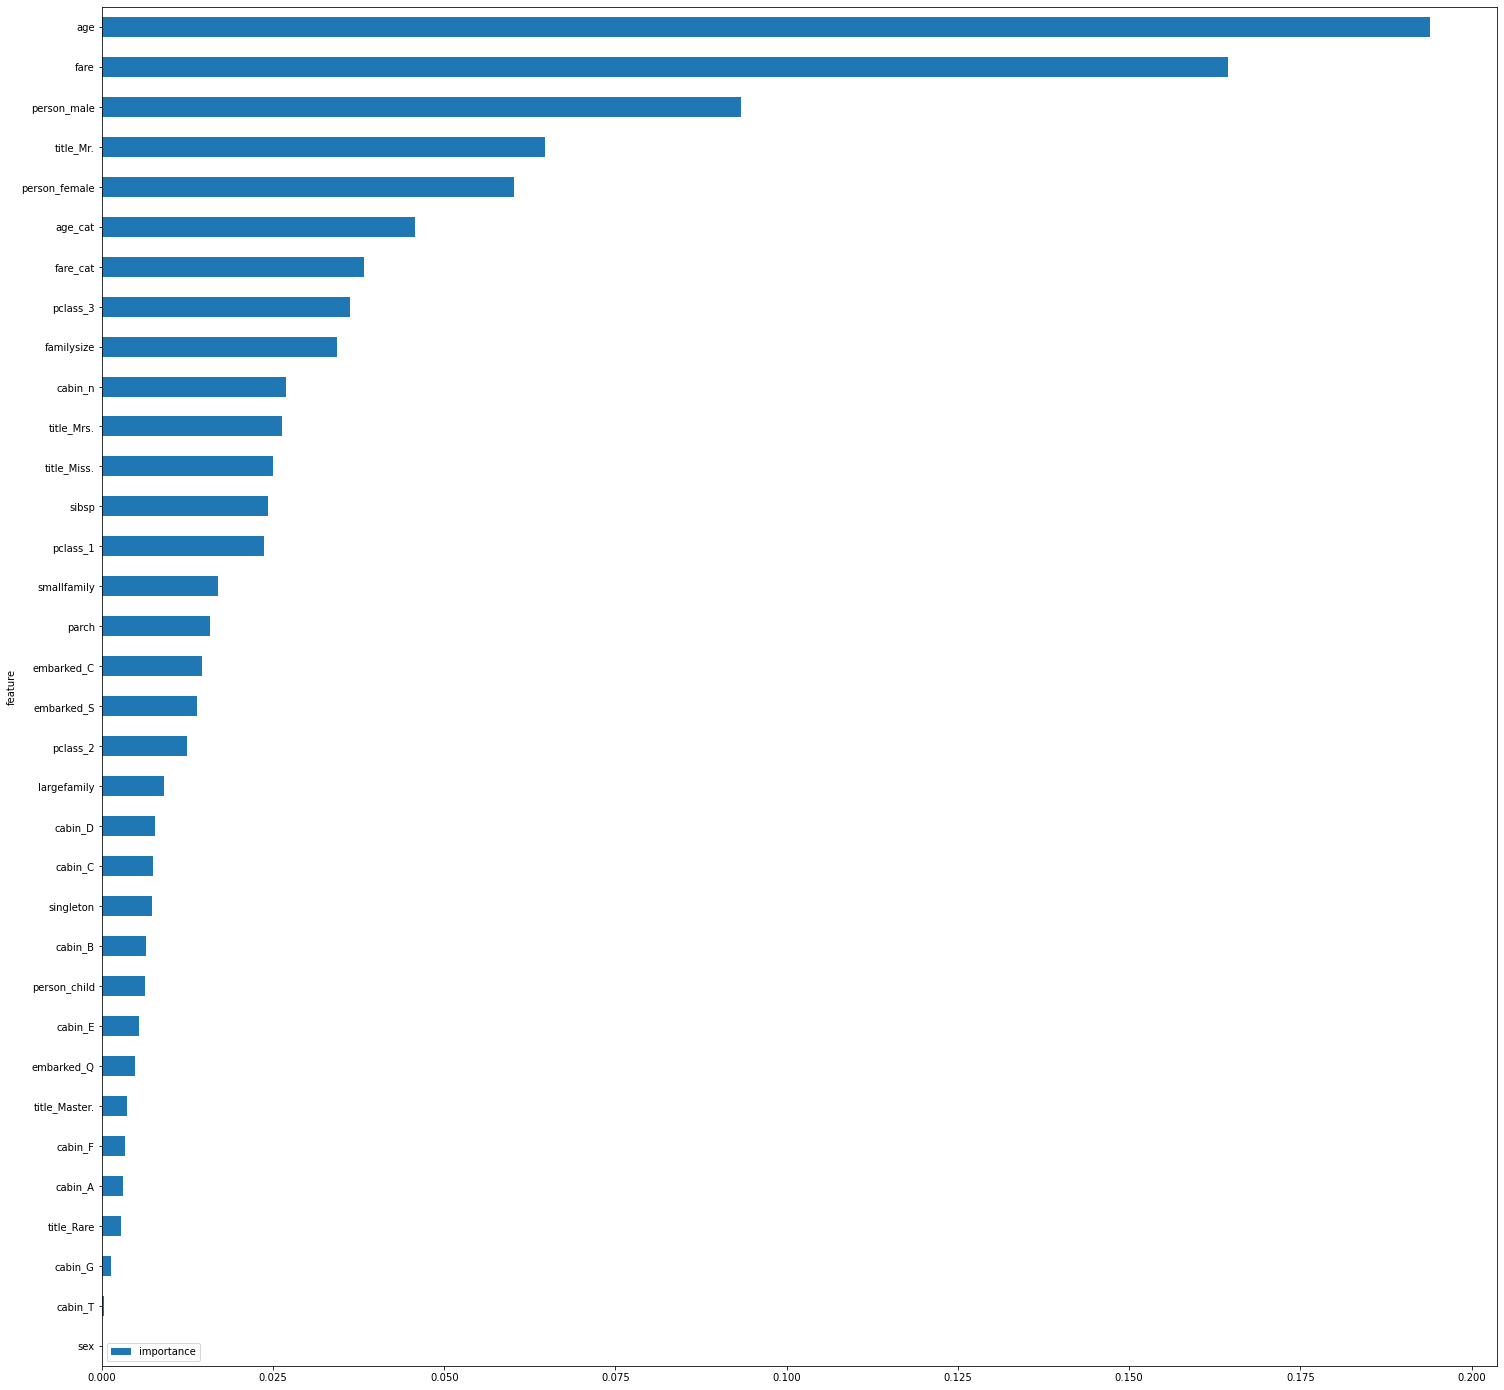

In [119]:
feature_importances = pd.DataFrame()
feature_importances['feature'] = X_train.columns
feature_importances['importance'] = clf.feature_importances_
feature_importances.sort_values(by=['importance'], ascending=True, inplace=True)
feature_importances.set_index('feature', inplace=True)

feature_importances.plot(kind='barh', figsize=(25, 25))

In [120]:
from sklearn.feature_selection import SelectFromModel
model = SelectFromModel(clf, prefit=True)
X_train = model.transform(X_train)
X_test = model.transform(X_test)
print(X_train.shape, X_test.shape)

(916, 9) (393, 9)


In [121]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

logreg = LogisticRegression(max_iter=1e5)
rf = RandomForestClassifier()
gboost = GradientBoostingClassifier()

models = [logreg, rf, gboost]

In [122]:
cross_validation = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [123]:
for model in models:
    print('Cross-validation of : {0}'.format(model.__class__))
    score = np.mean(cross_val_score(model, X_train, y_train, cv=cross_validation, scoring='accuracy'))
    print('CV score = {0}'.format(score))
    print('****')

Cross-validation of : <class 'sklearn.linear_model._logistic.LogisticRegression'>
CV score = 0.808945117605132
****
Cross-validation of : <class 'sklearn.ensemble._forest.RandomForestClassifier'>
CV score = 0.7947137087194107
****
Cross-validation of : <class 'sklearn.ensemble._gb.GradientBoostingClassifier'>
CV score = 0.8089213589926348
****


In [124]:
from sklearn.model_selection import RandomizedSearchCV
rfc=RandomForestClassifier(random_state=42)
param_grid = { 
    'n_estimators': [100, 150, 200],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [3,4,5,6,7,8]}

rfc_cv = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=cross_validation)
rfc_cv.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [3, 4, 5, 6, 7, 8],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [100, 150, 200]})

Tuned parameters and score

In [126]:
print("Tuned Random Forest Parameters: {}".format(rfc_cv.best_params_))
print("Best score is {}".format(rfc_cv.best_score_))
print("Score on test data is {}".format(rfc_cv.score(X_test, y_test)))

Tuned Random Forest Parameters: {'max_depth': 6, 'max_features': 'auto', 'n_estimators': 100}
Best score is 0.8274887146590639
Score on test data is 0.7938931297709924


In [127]:
from sklearn.metrics import confusion_matrix
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
y_hat_test = rfc_cv.predict(X_test)
confusion_matrix(y_test, y_hat_test, labels=[0,1])

array([[209,  15],
       [ 66, 103]])

In [128]:
y_test.value_counts()

0    224
1    169
Name: survived, dtype: int64

In [129]:
import matplotlib.pyplot as plt
from sklearn import metrics

Confusion matrix:
[[209  15]
 [ 66 103]]


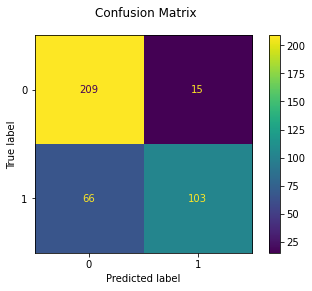

In [130]:
disp = metrics.plot_confusion_matrix(rfc_cv, X_test, y_test)
disp.figure_.suptitle("Confusion Matrix")
print(f"Confusion matrix:\n{disp.confusion_matrix}")

plt.show()

## MNIST handwritten digits

Based on sklearn documentation [example](https://scikit-learn.org/stable/auto_examples/classification/plot_digits_classification.html).

The images attribute of the dataset stores 8x8 arrays of grayscale values for each image.

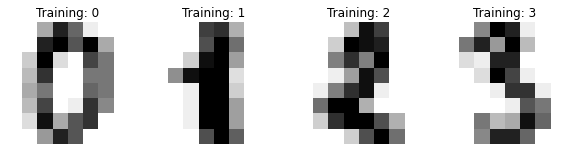

In [131]:
import matplotlib.pyplot as plt
from sklearn import datasets, svm
digits = datasets.load_digits()

_, axes = plt.subplots(nrows=1, ncols=4, figsize=(10, 3))
for ax, image, label in zip(axes, digits.images, digits.target):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title('Training: %i' % label)

In [132]:
# flatten the images
n_samples = len(digits.images)
data = digits.images.reshape((n_samples, -1))

# Create a classifier: a support vector classifier
clf = svm.SVC(gamma=0.001)

# Split data into 50% train and 50% test subsets
X_train, X_test, y_train, y_test = train_test_split(
    data, digits.target, test_size=0.5, shuffle=False)

# Learn the digits on the train subset
clf.fit(X_train, y_train)

# Predict the value of the digit on the test subset
predicted = clf.predict(X_test)


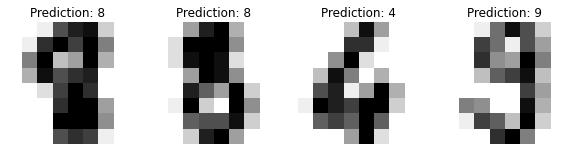

In [133]:
_, axes = plt.subplots(nrows=1, ncols=4, figsize=(10, 3))
for ax, image, prediction in zip(axes, X_test, predicted):
    ax.set_axis_off()
    image = image.reshape(8, 8)
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title(f'Prediction: {prediction}')

In [134]:
print(f"Classification report for classifier {clf}:\n"
      f"{metrics.classification_report(y_test, predicted)}\n")

Classification report for classifier SVC(gamma=0.001):
              precision    recall  f1-score   support

           0       1.00      0.99      0.99        88
           1       0.99      0.97      0.98        91
           2       0.99      0.99      0.99        86
           3       0.98      0.87      0.92        91
           4       0.99      0.96      0.97        92
           5       0.95      0.97      0.96        91
           6       0.99      0.99      0.99        91
           7       0.96      0.99      0.97        89
           8       0.94      1.00      0.97        88
           9       0.93      0.98      0.95        92

    accuracy                           0.97       899
   macro avg       0.97      0.97      0.97       899
weighted avg       0.97      0.97      0.97       899




Confusion matrix:
[[87  0  0  0  1  0  0  0  0  0]
 [ 0 88  1  0  0  0  0  0  1  1]
 [ 0  0 85  1  0  0  0  0  0  0]
 [ 0  0  0 79  0  3  0  4  5  0]
 [ 0  0  0  0 88  0  0  0  0  4]
 [ 0  0  0  0  0 88  1  0  0  2]
 [ 0  1  0  0  0  0 90  0  0  0]
 [ 0  0  0  0  0  1  0 88  0  0]
 [ 0  0  0  0  0  0  0  0 88  0]
 [ 0  0  0  1  0  1  0  0  0 90]]


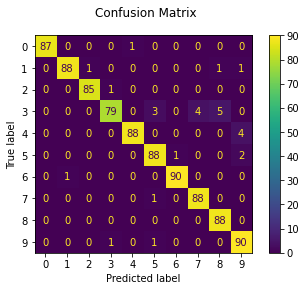

In [135]:
disp = metrics.plot_confusion_matrix(clf, X_test, y_test)
disp.figure_.suptitle("Confusion Matrix")
print(f"Confusion matrix:\n{disp.confusion_matrix}")

plt.show()